In [1]:
import torch
import ray
import gym
from IPython import display
import ray.rllib.agents.dqn as dqn
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
print(torch.cuda.is_available())

True


In [3]:
import logging

from ray.rllib.models.torch.torch_modelv2 import TorchModelV2
from ray.rllib.utils.annotations import override
from ray.rllib.utils.framework import try_import_torch

torch, nn = try_import_torch()

logger = logging.getLogger(__name__)


class ConvNet(TorchModelV2, nn.Module):
    """Generic fully connected network."""

    def __init__(self, obs_space, action_space, num_outputs, model_config,
                 name):
        TorchModelV2.__init__(self, obs_space, action_space, num_outputs,
                              model_config, name)
        nn.Module.__init__(self)
        in_channels = obs_space.shape[-1]
        self._conv_layers = nn.Sequential(
            torch.nn.Conv2d(in_channels, 8, kernel_size=[7,7], padding=3),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(2, stride=2, padding=1),
            torch.nn.Conv2d(8, 16, kernel_size=[5,5], padding=2),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(2, stride=2, padding=1),
            torch.nn.Conv2d(16, 32, kernel_size=[3,3], padding=1),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(2, stride=2, padding=1),
            torch.nn.Conv2d(32, num_outputs, kernel_size=[12,12])
        )
        self._features = None
        self._num_outputs = num_outputs

        

    @override(TorchModelV2)
    def forward(self, input_dict, state, seq_lens):
        obs = input_dict["obs"].float().permute(0,3,1,2) #reshape input
        self._features = self._conv_layers(obs).view(-1, self._num_outputs)
        return self._features, state


In [4]:
from ray.tune.registry import register_env
from ray.rllib.agents import dqn
import numpy as np
class MultiFrameBreakout(gym.Env):
    def __init__(self, env_config):
        self.env = gym.make('Breakout-v0')
        self.action_space = self.env.action_space
        self.observation_space = self.env.observation_space
    def reset(self):
        return self.env.reset()
    def step(self, action):
        return self.env.step(action)

In [13]:
#RLLIB DEFAULT

from ray.rllib.agents import dqn

config = dqn.DEFAULT_CONFIG.copy()
config['framework'] = 'torch'
config['output'] = '/tmp/breakout_out'
trainer = dqn.DQNTrainer(env='BreakoutNoFrameskip-v4', config=config)
policy = trainer.get_policy()
model = policy.q_model
env = trainer.workers.local_worker().env
print(config)
for i in range(5):
    episode_reward_mean = trainer.train()['episode_reward_mean']
    if i % 1 == 0:
        print(episode_reward_mean)
    if i % 20 == 0:
        checkpoint = trainer.save()
        print('checkpoint saved at', checkpoint)

2020-11-03 11:58:21,832	WARNING util.py:39 -- Install gputil for GPU system monitoring.


{'num_workers': 0, 'num_envs_per_worker': 1, 'rollout_fragment_length': 4, 'batch_mode': 'truncate_episodes', 'num_gpus': 0, 'train_batch_size': 32, 'model': {'fcnet_hiddens': [256, 256], 'fcnet_activation': 'tanh', 'conv_filters': None, 'conv_activation': 'relu', 'free_log_std': False, 'no_final_linear': False, 'vf_share_layers': True, 'use_lstm': False, 'max_seq_len': 20, 'lstm_cell_size': 256, 'lstm_use_prev_action_reward': False, '_time_major': False, 'framestack': True, 'dim': 84, 'grayscale': False, 'zero_mean': True, 'custom_model': None, 'custom_model_config': {}, 'custom_action_dist': None, 'custom_preprocessor': None}, 'optimizer': {}, 'gamma': 0.99, 'horizon': None, 'soft_horizon': False, 'no_done_at_end': False, 'env_config': {}, 'env': None, 'normalize_actions': False, 'clip_rewards': None, 'clip_actions': True, 'preprocessor_pref': 'deepmind', 'lr': 0.0005, 'monitor': False, 'log_level': 'WARN', 'callbacks': <class 'ray.rllib.agents.callbacks.DefaultCallbacks'>, 'ignore_w

In [ ]:
#CUSTOM ENVIRONMENT

register_env("multiframe", lambda config: MultiFrameBreakout(config))
config = dqn.DEFAULT_CONFIG.copy()
config['framework'] = 'torch'
config['num_gpus'] = 2
trainer = dqn.DQNTrainer(env='multiframe', config=config)
policy = trainer.get_policy()
model = policy.q_model

env = trainer.workers.local_worker().env
print(env.observation_space)
"""for i in range(100):
    print(trainer.train()['episode_reward_mean'])"""

In [ ]:
#CUSTOM MODEL

"""from ray.rllib.models import ModelCatalog

ray.shutdown()

ModelCatalog.register_custom_model("ConvNet", ConvNet)

ray.init()
trainer = dqn.DQNTrainer(env="BreakoutNoFrameskip-v4", config={
    "framework": "torch",
    "hiddens": [256,256],
    "num_gpus": 2,
    "preprocessor_pref": "deepmind",
    "model": {
        "custom_model": "ConvNet",
        # Extra kwargs to be passed to your model's c'tor.
        "custom_model_config": {},
        "use_lstm": False,
        "framestack": True
    },
    "lr": 1e-5,
    "exploration_config": {
        "epsilon_timesteps": 100000,
    },
    "output": "/tmp/breakout_out1",
    "monitor": True
})"""


policy = trainer.get_policy()
model = policy.q_model
print(model)
for i in range(600):
    episode_reward_mean = trainer.train()['episode_reward_mean']
    if i % 1 == 0:
        print(episode_reward_mean)
    if i % 20 == 0:
        checkpoint = trainer.save()
        print('checkpoint saved at', checkpoint)

ConvNet_as_DQNTorchModel(
  (_conv_layers): Sequential(
    (0): Conv2d(4, 8, kernel_size=[7, 7], stride=(1, 1), padding=(3, 3))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=1, dilation=1, ceil_mode=False)
    (3): Conv2d(8, 16, kernel_size=[5, 5], stride=(1, 1), padding=(2, 2))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=1, dilation=1, ceil_mode=False)
    (6): Conv2d(16, 32, kernel_size=[3, 3], stride=(1, 1), padding=(1, 1))
    (7): ReLU()
    (8): MaxPool2d(kernel_size=2, stride=2, padding=1, dilation=1, ceil_mode=False)
    (9): Conv2d(32, 256, kernel_size=[12, 12], stride=(1, 1))
  )
  (advantage_module): Sequential(
    (dueling_A_0): SlimFC(
      (_model): Sequential(
        (0): Linear(in_features=256, out_features=256, bias=True)
        (1): ReLU()
      )
    )
    (dueling_A_1): SlimFC(
      (_model): Sequential(
        (0): Linear(in_features=256, out_features=256, bias=True)
        (1): ReLU()
      )
    )
    (A): Sli

In [ ]:
#CUSTOM MODEL AND CUSTOM ENVIRONMENT

from ray.rllib.models import ModelCatalog

ray.shutdown()

ModelCatalog.register_custom_model("ConvNet", ConvNet)

ray.init()
trainer = dqn.DQNTrainer(env=MultiFrameBreakout, config={
    "framework": "torch",
    "hiddens": [256,256],
    "num_gpus": 2,
    "preprocessor_pref": "deepmind",
    "model": {
        "custom_model": "ConvNet",
        # Extra kwargs to be passed to your model's c'tor.
        "custom_model_config": {},
        "use_lstm": True
    },
})


policy = trainer.get_policy()
model = policy.q_model
print(model)

env = trainer.workers.local_worker().env
print(env.observation_space)
for i in range(100):
    episode_reward_mean = trainer.train()['episode_reward_mean']
    if i % 1 == 0:
        print(episode_reward_mean)
    if i % 100 == 0:
        checkpoint = trainer.save()
        print('checkpoint saved at', checkpoint)

"env = copy.deepcopy(trainer.workers.local_worker().env)\nfor i in range(10):\n    episode_reward = 0\n    done = False\n    obs = env.reset()\n    \n    while not done:\n        action = trainer.compute_action(obs)\n        obs, reward, done, info = env.step(action)\n        episode_reward += reward\n        plt.imshow(env.render(mode='rgb_array'))\n        display.display(plt.gcf())\n        display.clear_output(wait=True)"

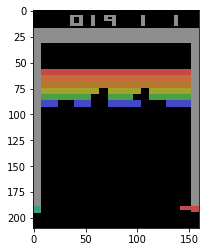

In [16]:
from IPython import display
import copy


env = trainer.workers.local_worker().env
plt.imshow(env.render(mode='rgb_array'))
display.display(plt.gcf())
display.clear_output(wait=True)
"""obs, reward, done, info = env.step(env.action_space.sample())
for i in range(10):
    while not done:
        action = trainer.compute_action(obs)
        obs, reward, done, info = env.step(action)
        plt.imshow(env.render(mode='rgb_array'))
        display.display(plt.gcf())
        display.clear_output(wait=True)"""
"""env = copy.deepcopy(trainer.workers.local_worker().env)
for i in range(10):
    episode_reward = 0
    done = False
    obs = env.reset()
    
    while not done:
        action = trainer.compute_action(obs)
        obs, reward, done, info = env.step(action)
        episode_reward += reward
        plt.imshow(env.render(mode='rgb_array'))
        display.display(plt.gcf())
        display.clear_output(wait=True)"""

In [14]:
trainer = dqn.DQNTrainer(env="BreakoutNoFrameskip-v4", config={
    "framework": "torch",
    "hiddens": [256,256],
    "num_gpus": 2,
    "preprocessor_pref": "deepmind",
    "model": {
        "custom_model": "ConvNet",
        # Extra kwargs to be passed to your model's c'tor.
        "custom_model_config": {},
        "use_lstm": False,
        "framestack": True
    },
    "lr": 1e-5,
    "exploration_config": {
        "epsilon_timesteps": 100000,
    },
})
trainer.restore('/home/wangjim19/ray_results/DQN_BreakoutNoFrameskip-v4_2020-11-01_17-52-565elpxf2c/checkpoint_301/checkpoint-301')
print(trainer.train()['episode_reward_mean'])

2020-11-03 12:30:51,806	WARNING util.py:39 -- Install gputil for GPU system monitoring.
2020-11-03 12:30:51,856	INFO trainable.py:482 -- Restored on 128.32.112.46 from checkpoint: /home/wangjim19/ray_results/DQN_BreakoutNoFrameskip-v4_2020-11-01_17-52-565elpxf2c/checkpoint_301/checkpoint-301
2020-11-03 12:30:51,857	INFO trainable.py:489 -- Current state after restoring: {'_iteration': 301, '_timesteps_total': None, '_time_total': 4230.372759342194, '_episodes_total': 662}


1.1666666666666667


In [11]:
trainer.config['output'] = '/tmp/breakout_out'
print(trainer.train()['episode_reward_mean'])

1.2571428571428571
